# The Metropolis-Hastings Algorithm
#### En el presente trabajo se implementa el algoritmo de Metropolis-Hastings en el cual por default y como una forma de comprobar los resultados se adapta para el caso de un modelo lineal de un conjunto de datos.

#### Se importan las librerías a utilizar.

In [68]:
import numpy as np
import scipy
import scipy.stats
import matplotlib as mpl   
import matplotlib.pyplot as plt
import pandas as pd
from numpy import random

#### En especial se importan dos distribuciones que serán de utilidad en el algoritmo. Estas son las distribuciones de probabilidad consideradas para calcular el PRIOR de cada parámetro.

In [69]:
from scipy.stats import distributions
dgamma = distributions.gamma.logpdf
dnorm = distributions.norm.logpdf

#### Se cargan los datos que se analizarán.

In [70]:
data=np.load('fit_exercise.npy')
xd=data[0]
yd=data[1]
yderror=data[2]

Text(0, 0.5, 'y')

<Figure size 432x288 with 0 Axes>

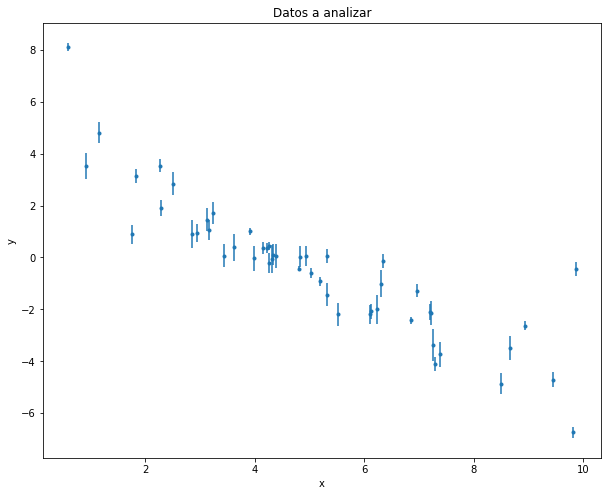

In [71]:
plt.figure()
plt.figure(figsize=(10,8))
plt.errorbar(xd, yd, yderror,fmt='.')
plt.title("Datos a analizar")
plt.xlabel("x")
plt.ylabel("y")

#### Se define una función que permita el cálculo del POSTERIOR $\ln\left(P\left(\theta\left|D\right.\right)\right)$, es decir $\ln\left(P\left(\theta\left|D\right.\right)\right)\propto\ln\left(L\left(D\left|\theta\right.\right)\right)+\ln\left(P(\theta)\right)$
#### Esta función depende del conjunto de parámetros $\theta$ según el modelo y los datos. En el caso de un modelo lineal este conjunto de parámetros son $a$, $b$, $t$. Se calcula el $\ln\left(P\left(\theta\left|D\right.\right)\right)$ como la contribución de: 
#### 1. Suma del logaritmo de la probabilidad de $a$ y $b$ según la distribución normal con media igual a cero y una desviación estándar de 10000. 
#### 2. El logaritmo de la probabilidad de $t$ según la distribución gamma y parámetros de forma iguales a $0.001$. y 
#### 3. Sumando el likelihood que en este caso se asume que es gaussiano, donde $y$ y $x$ son los datos observados y $\mu$ es el modelo que se pretende construir dados los parámetros. 
#### *Recordar que se trabaja con logaritmos de las probabilidades, pues es mejora la convergencia del método.

In [72]:
def posterior(a, b, t, y=yd, x=xd):
    #Priors de a + b
    logposterior = dnorm(a, 0, 10000) + dnorm(b, 0, 10000)
    #Prior del parámetro t
    logposterior += dgamma(t, 0.001, 0.001)
    #Media=Modelo
    mu = a + b*x
    #Likelihood
    logposterior += sum(dnorm(y, mu, t**-2))
    
    return logposterior

### Algoritmo de Metropolis-Hastings
**Considerando un walker**

In [73]:
def metropolis(iteraciones, valores_iniciales, var_prop):

    n_param = len(valores_iniciales)
    
    #Desviaciones estándar iniciales propuestas 
    sd_prop = [var_prop]*n_param #crea un vector con valores iguales a var_prop (Desviación estándar propuesta) 
                                 #con elementos iguales al número de parámetros.
    #Almacenamiento de parámetros calculados.
    Reserv_param = np.empty((iteraciones+1, n_param)) #crea un arreglo vacío con n_param columnas y iteraciones+1 filas dado que en la 
    #fila uno van los valores guess.
    Reserv_param_re = np.zeros((iteraciones+1, n_param)) 
    #Introduce los valores iniciales de los parámetros.
    Reserv_param[0] = valores_iniciales #Llena la primer fila con los valores guess.
    Reserv_param_re[0] = valores_iniciales 
    
    #Se calcula el posterior incial (actual) 
    posterior_1 = posterior(*Reserv_param[0]) #Agrega los parámetros (a,b,t) como vector a la función que calcula el posterior   
    
    
    rnorm = np.random.normal
    runif = np.random.rand
    
    #fin=len(Reserv_param) #************
    #plt.figure(figsize=(20,10)) #************
    
    for i in range(iteraciones):
        
        valores_param = Reserv_param[i] #Toma la fila i-ésima de valores para los parámetros del almacenamiento.
    
        for j in range(n_param): #CORRE SOBRE EL NÚMERO DE PARÁMETROS (debido a las dos diferentes funciones de distribución 
                                 #de probabilidad). En el caso del modelo lineal de 1 a 3.
    
            p = Reserv_param[i].copy() #Realiza una copia de la fila i-esima, p amacenará o no los parámetros nuevos dada la comparación
                                       #Simplemente se pretende tomar la estructura del arreglo.
    
            #SE GENERAN MUESTRAS ALEATORIAS DE VALORES CENTRADOS EN NUESTROS VALORES ACTUALES DE LOS PARÁMETROS
            if j==2:
                alpha = np.exp(rnorm(np.log(valores_param[j]), sd_prop[j]))
            else:
                alpha = rnorm(valores_param[j], sd_prop[j])
            
            #Se llena el vector p con las muestras calculadas.
            p[j] = alpha #AGREGA VALORES CALCULADOS en la columna j-ésima del vector P  que es copia de la i-ésima fila 
                         #de Reserv_param para calcular el nuevo posterior.
    
            
            posterior_2 = posterior(*p) #Calcula el posterior nuevo.
    
            r = posterior_2 - posterior_1
    
            #Muestra de una variable aleatoria uniforme entre 0-1
            va = runif()

            #Comparación
            if np.log(va) < r: #Se acepta
                Reserv_param[i+1,j] = alpha #Almacenamos los valores nuevos de los parámetros.
                posterior_1= posterior_2
            
            else: #Se rechaza
                Reserv_param[i+1,j] = Reserv_param[i,j] #Almacenamos los valores antiguos de los parámetros.
                Reserv_param_re[i+1,j] = Reserv_param[i,j]
                
    return Reserv_param, Reserv_param_re

### Sea el número de iteraciones igual a $2000$, los parámetros $a=0.1$, $b=0.1$ y $t=0.5$ y la varianza igual a $0.1$:

In [74]:
Reserv_param, Reserv_param_re = metropolis(2000,(.1,.1,.5),0.1)

Gráfica de los parámetros 

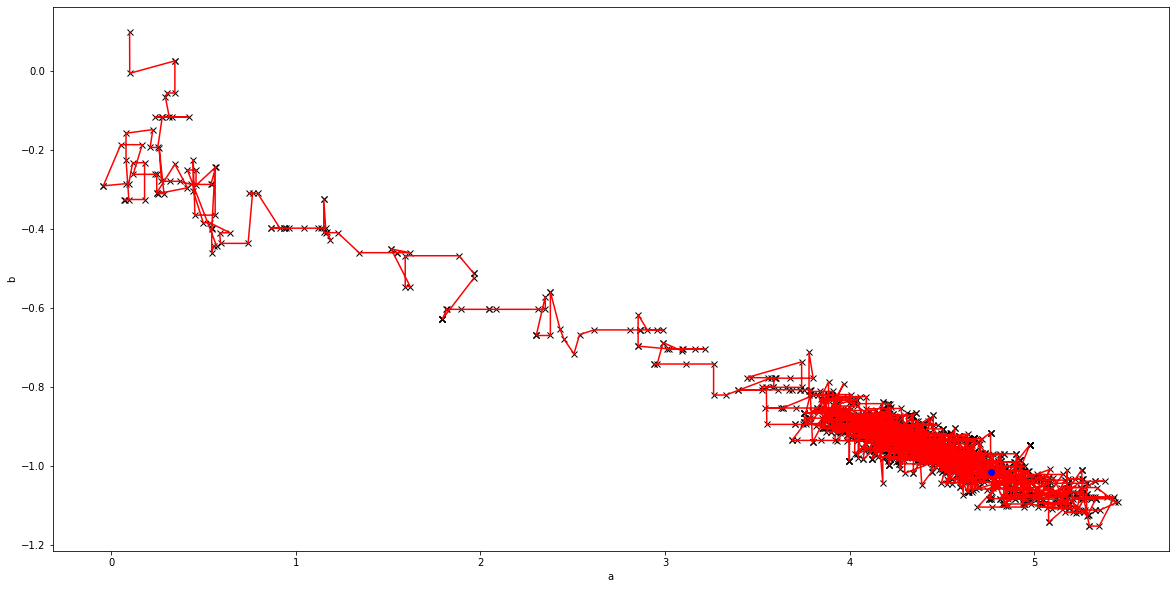

In [75]:
fin=len(Reserv_param)
plt.figure(figsize=(20,10))
plt.plot(Reserv_param[:,0],Reserv_param[:,1],'kx')
plt.plot(Reserv_param[:,0],Reserv_param[:,1],'r')
plt.plot(Reserv_param[fin-1,0],Reserv_param[fin-1,1],'bo')
plt.xlabel("a")
plt.ylabel("b")
plt.show()

In [76]:
Reserv_param

array([[ 0.1       ,  0.1       ,  0.5       ],
       [ 0.10078466, -0.00489355,  0.5       ],
       [ 0.3452748 ,  0.02664099,  0.54020246],
       ...,
       [ 4.87412673, -1.01484984,  0.95079432],
       [ 4.75099325, -1.01484984,  0.95079432],
       [ 4.76277981, -1.01484984,  0.95079432]])

In [77]:
df=pd.DataFrame(Reserv_param_re)
RPR=df[~(df == 0).any(axis=1)]
Reserv_param_rec=RPR.to_numpy()
#Reserv_param_rec

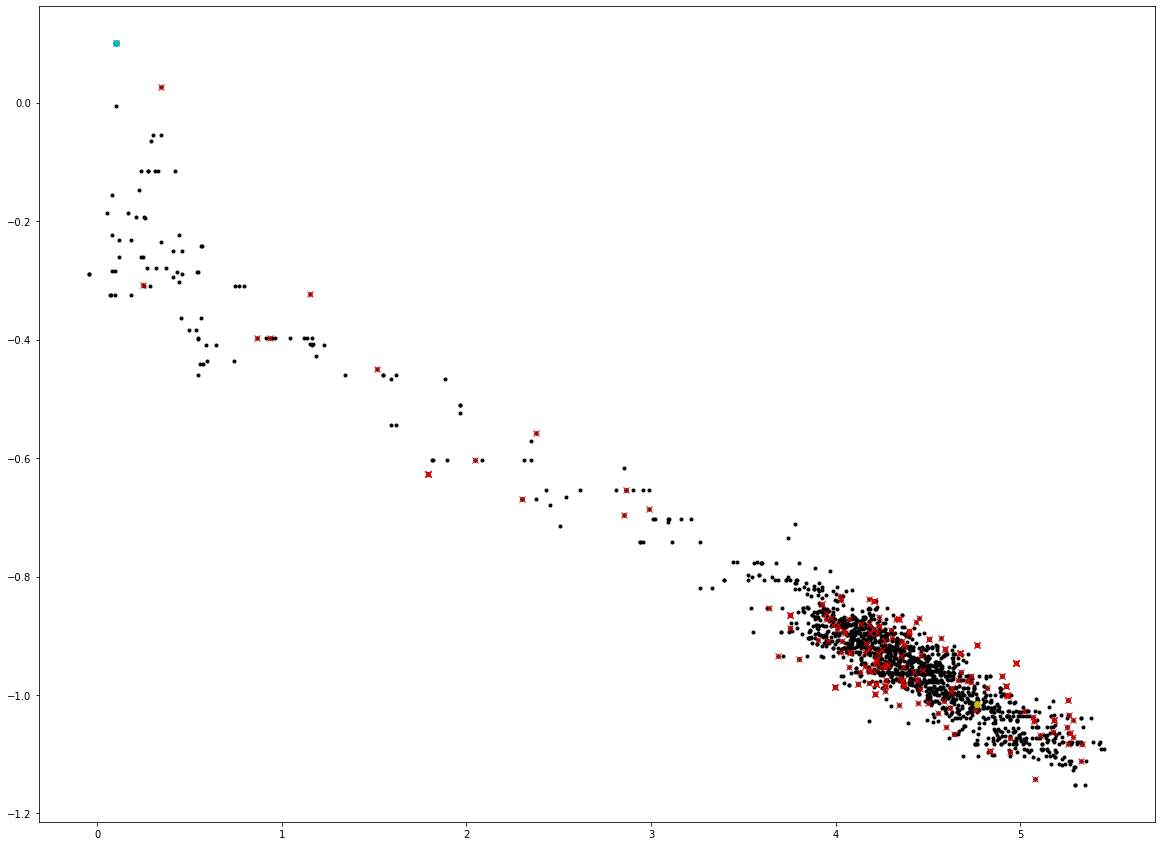

In [78]:
plt.figure(figsize=(20,15))
plt.plot(Reserv_param[:,0],Reserv_param[:,1],'k.')
plt.plot(Reserv_param_rec[:,0],Reserv_param_rec[:,1],'rx')
fin=len(Reserv_param)
plt.plot(Reserv_param[fin-1,0],Reserv_param[fin-1,1],'yo')
plt.plot(Reserv_param[0,0],Reserv_param[0,1],'co')
plt.show()

In [80]:
#Reserv_param_rec

# Algoritmo de Metropolis-Hastings con Implementación de Varios walkers.

In [81]:
n_param=3 #Número de parámetros
nc=4 #Número de walkers - Número de cadenas
iteraciones=7000 #Número de iteraciones
CA=random.uniform(.5, size=(nc, n_param)) #Matriz que almacena los valores guess para cada walker. Se toman valores aleatorios entre [0,.5]
T_cam=np.empty((nc,iteraciones+1,n_param)) #Tensor que acumula la evolución de los walkers 

for l in range(nc):
    Reserv_param, Reserv_param_re = metropolis(iteraciones,CA[l-1],0.1)
    T_cam[l]=Reserv_param


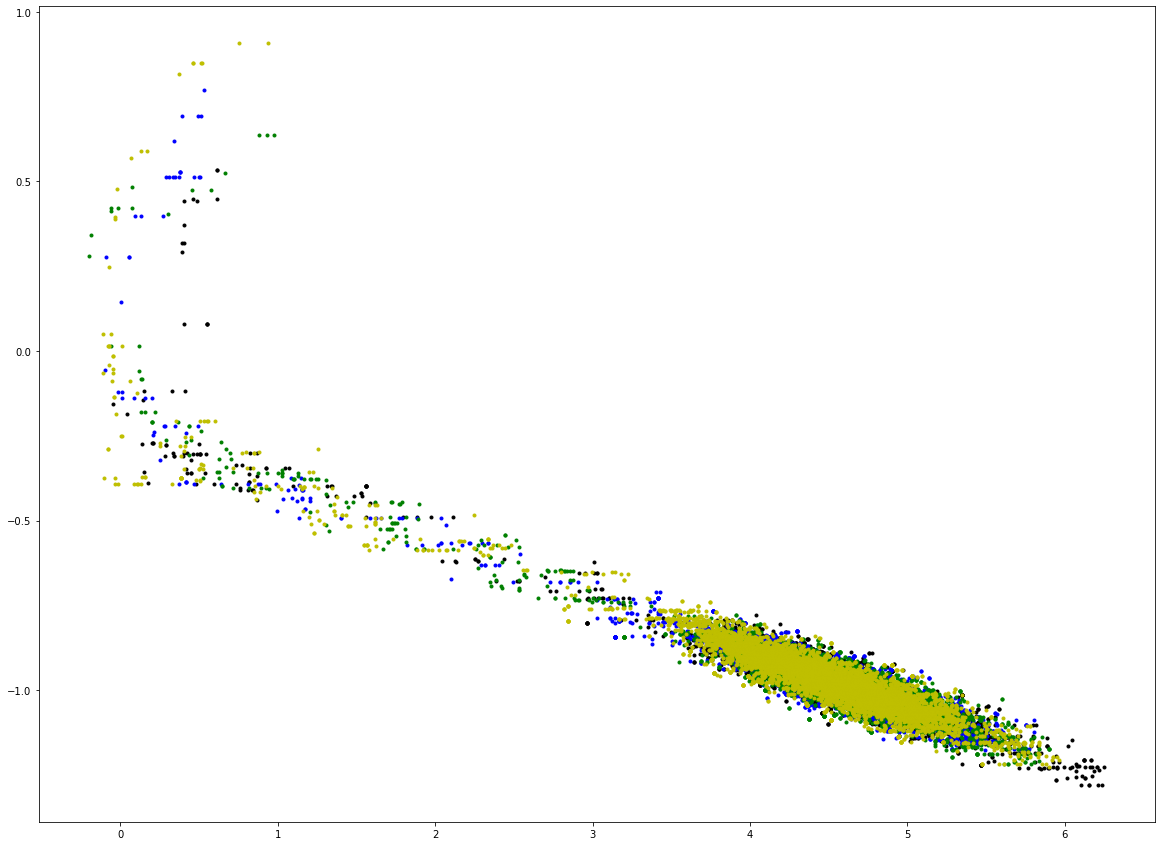

In [82]:
plt.figure(figsize=(20,15))
plt.plot(T_cam[0,:,0],T_cam[0,:,1],'k.')
plt.plot(T_cam[1,:,0],T_cam[1,:,1],'b.')
plt.plot(T_cam[2,:,0],T_cam[2,:,1],'g.')
plt.plot(T_cam[3,:,0],T_cam[3,:,1],'y.')

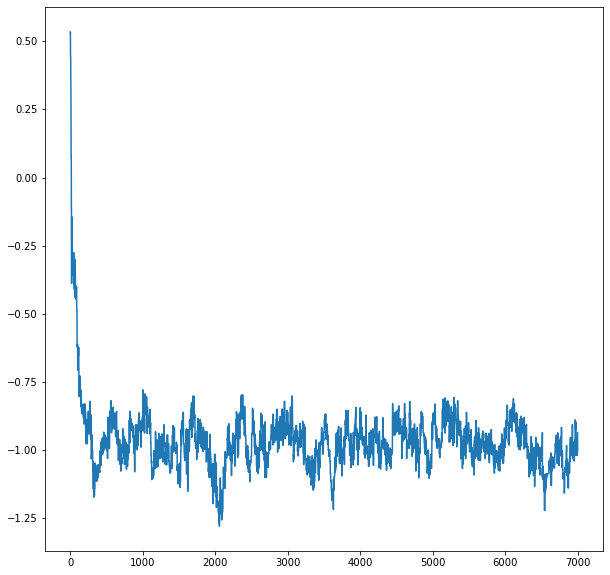

In [83]:
#plt.plot(np.arange(iteraciones+1),T_cam[0,:,0])
plt.figure(figsize=(10,10))
plt.plot(np.arange(T_cam[0,:,1].shape[0]),T_cam[0,:,1])

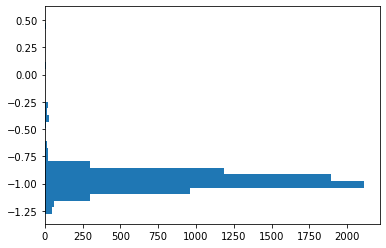

In [84]:
plt.hist(T_cam[0,:,1],orientation='horizontal',bins=30)
plt.show()

# Diagnostico de Gelman-Rubin (una manera de examinar la convergencia).
**Descripción:**

**If our MH MCMC Chain reaches a stationary distribution, and we repeat the excercise multiple times, then we can examine if the posterior for each chain converges to the same place in the distribution of the parameter space.**

Steps:

1. Run M>1 Chains of length 2×N.
2. Discard the first N draws of each chain, leaving N iterations in the chain.
3. Calculate the within and between chain variance.

- Within chain variance: $W=\frac1M\sum_{j=1}^Ms_j^2$ \
where $s_j^2$ is the variance of each chain (after throwing out the first N draws).
- Between chain variance: $B=\frac M{N-1}\sum_{j=1}^M\left({\overline\theta}_j-\overline{\overline\theta}\right)^2$ \
where $\overline{\overline\theta}$ is the mean of each of the M means.
4. Calculate the estimated variance of $\theta$ as the weighted sum of between and within chain variance.

$var\left(\theta\right)=\left(1-\frac1N\right)W+\frac1NB$

5. Calculate the potential scale reduction factor.

$R=\sqrt{\frac{var\left(\theta\right)}W}$

***We want this number to be close to 1. Why? This would indicate that the between chain variance is small. This makes sense, if between chain variance is small, that means both chains are mixing around the stationary distribution.*** 

In [85]:
N=iteraciones 
R=np.zeros((1,n_param)) #Arreglo que almacena the potential scale reduction factor para cada parámetro.
for k in range(n_param): #El ciclo en k recorre sobre los parámetros.
    W_sum=0
    meansum=0
    B=0
    for i in range(nc): #Se calculan sumatorias necesarias.
        W_sum = W_sum+T_cam[i,:,k].std()**2
        meansum=meansum+T_cam[i,:,k].mean()
    W=W_sum/nc
    mean=meansum/nc
    for j in range(nc):
        B=B+(N/(nc-1))*(T_cam[j,:,k].mean()-mean)**2
        var_theta=(1-1/N)*W+(1/N)*B
    R[0,k-1]=(var_theta/W)**(.5) #Almacenando el valor de R por parámetro
R

array([[1.00195188, 1.0008705 , 1.00302302]])